### Imports

In [1]:
import sys
mypath = "/home/basia/Documents/spectroscopy/magnetstein"
sys.path.insert(0, mypath)

In [2]:
import numpy as np
import pandas as pd
import os
from masserstein import NMRSpectrum, estimate_proportions
import matplotlib.pyplot as plt
import pulp
import pickle

### Data

In [3]:
experiment_name = 'Saccharose hydrolysis with full mixture spectrum'

In [4]:
mixture_paths = {
                'Saccharose hydrolysis': '../data/saccharose_hydrolysis/preprocessed_mixture.csv',
                'PMG 284 monitoring': '../data/PMG_284/preprocessed_mixture.csv',
                'PMG 287 monitoring': '../data/PMG_287/preprocessed_mixture_cut_to_regions.csv',
                'Saccharose hydrolysis with full mixture spectrum': '../data/saccharose_hydrolysis_full_mixture_spectrum/preprocessed_mixture.csv'
                }

reagents_paths = {
                'Saccharose hydrolysis': ['../data/saccharose_hydrolysis/preprocessed_saccharose.csv', 
                                            '../data/saccharose_hydrolysis/preprocessed_alpha_glucose.csv',
                                            '../data/saccharose_hydrolysis/preprocessed_beta_glucose.csv',
                                            '../data/saccharose_hydrolysis/preprocessed_fructose.csv'],
                'PMG 284 monitoring': ['../data/PMG_284/preprocessed_pentene.csv',
                                      '../data/PMG_284/preprocessed_triethylsilane.csv',
                                      '../data/PMG_284/preprocessed_product.csv'],
                'PMG 287 monitoring': ['../data/PMG_287/preprocessed_hexene.csv',
                                      '../data/PMG_287/preprocessed_triethylsilane.csv',
                                      '../data/PMG_287/preprocessed_product.csv'],
                'Saccharose hydrolysis with full mixture spectrum': [
                                            '../data/saccharose_hydrolysis_full_mixture_spectrum/preprocessed_saccharose.csv', 
                                            '../data/saccharose_hydrolysis_full_mixture_spectrum/preprocessed_alpha_glucose.csv',
                                            '../data/saccharose_hydrolysis_full_mixture_spectrum/preprocessed_beta_glucose.csv',
                                            '../data/saccharose_hydrolysis_full_mixture_spectrum/preprocessed_fructose.csv'
                                                                        ]
}

mixture_separators = {
                        'Saccharose hydrolysis': '\t',
                        'PMG 284 monitoring': '\t',
                        'PMG 287 monitoring': '\t',
                        'Saccharose hydrolysis with full mixture spectrum': '\t'
                        }

reagents_separators = {
                'Saccharose hydrolysis': '\t',
                'PMG 284 monitoring': '\t',
                'PMG 287 monitoring': '\t',
                'Saccharose hydrolysis with full mixture spectrum': '\t'
                }

results_paths = {
                'Saccharose hydrolysis': '../results/saccharose_hydrolysis/',
                'PMG 284 monitoring': '../results/PMG_284/',
                'PMG 287 monitoring': '../results/PMG_287/cut_spectrum_of_mixture/',
                'Saccharose hydrolysis with full mixture spectrum': '../results/saccharose_hydrolysis_full_mixture_spectrum/'
                }

#### Mixture in time

In [5]:
mixture_time_data = pd.read_csv(mixture_paths[experiment_name], sep = mixture_separators[experiment_name])
if experiment_name == 'Saccharose hydrolysis':
    ppm = mixture_time_data.iloc[:,0:1]
    every_10th = mixture_time_data.iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)
elif experiment_name == 'PMG 284 monitoring':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)
elif experiment_name == 'PMG 287 monitoring':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)
elif experiment_name == 'Saccharose hydrolysis with full mixture spectrum':
    ppm = mixture_time_data.iloc[:,0:1]
    every_10th = mixture_time_data.iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)

In [6]:
names = ['ppm'] + ['t' + str(nb) for nb in range(1, mixture_time_data.shape[1])]

In [7]:
mixture_time_data.columns = names

In [8]:
def load_spectrum(mixture_time_data, moment_of_time):
    ppm = mixture_time_data['ppm']
    intensity = mixture_time_data['t'+str(moment_of_time)]
    sp = NMRSpectrum(confs = list(zip(ppm, intensity)))
    sp.trim_negative_intensities()
    sp.normalize()
    return sp

#### Reagents

In [9]:
reagents_spectra = []
for reagent in reagents_paths[experiment_name]:
    reag = pd.read_csv(reagent, sep=reagents_separators[experiment_name], header=None).iloc[:,:2]
    reagents_spectra.append(reag)

In [10]:
reagents_spectra2 = []
for reag in reagents_spectra:
    ppm = reag.iloc[:,0]
    ints = reag.iloc[:,1]
    sp = NMRSpectrum(confs = list(zip(ppm, ints)))
    reagents_spectra2.append(sp)
reagents_spectra = reagents_spectra2
del(reagents_spectra2)

In [11]:
for sp in reagents_spectra:
    sp.trim_negative_intensities()
    sp.normalize()

In [12]:
reagents_spectra

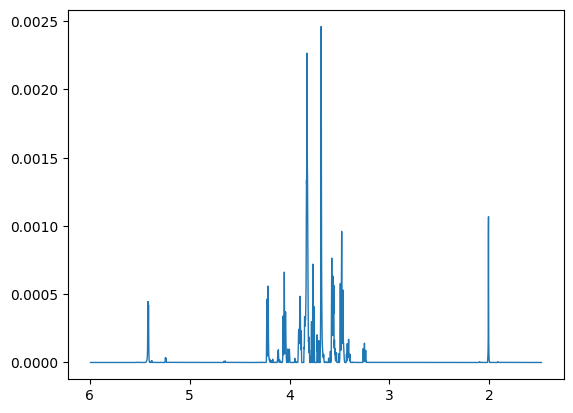

In [13]:
plt.gca().invert_xaxis()
NMRSpectrum.plot(load_spectrum(mixture_time_data, 30), profile=True)
#NMRSpectrum.plot_all(reagents_spectra + [load_spectrum(mixture_time_data, 100)], profile=True)

### Estimation

In [14]:
kappa = 0.01
kappa_th = 0.01

In [ ]:
proportions_in_times = []
noise_proportions_in_times = []
noise = []
noise_in_components = []

for i in range(1, mixture_time_data.shape[1]):
    print('This is timepoint '+str(i)+'.\n')
    mix = load_spectrum(mixture_time_data, i)
    mix.trim_negative_intensities()
    mix.normalize()
    estimation = estimate_proportions(mix, reagents_spectra, what_to_compare='area', 
                                      solver=pulp.GUROBI(msg=False),
                                     MTD=kappa, MTD_th=kappa_th)
    proportions_in_times.append(estimation['proportions'])
    noise_proportions_in_times.append(estimation['proportion_of_noise_in_components'])
    noise.append(estimation['noise'])
    noise_in_components.append(estimation['noise_in_components'])
#     if i>1:
#         assert estimation['common_horizontal_axis'] == common_horizontal_axis
    common_horizontal_axis = estimation['common_horizontal_axis']
    
    print('Proportions:\n')
    print(estimation['proportions'])
    print('\n')
    print('Proportion_of_noise_in_components:\n')
    print(estimation['proportion_of_noise_in_components'])
    print('\n')

This is timepoint 1.

Proportions:

[0.0351052078349941, 8.236031519953365e-05, 6.823677958929434e-06, 0.00011003842086495731]


Proportion_of_noise_in_components:

0.0037915884451032067


This is timepoint 2.

Proportions:

[0.035409972538125854, 0.00020190212651891013, 1.2212456787959662e-05, 0.00031543555030537]


Proportion_of_noise_in_components:

0.003850068907236473


This is timepoint 3.

Proportions:

[0.034856610646196405, 0.00030314716622719605, 1.746964634819589e-05, 0.0005803170845442044]


Proportion_of_noise_in_components:

0.0035618849224124515


This is timepoint 4.

Proportions:

[0.03450829984079095, 0.0003891139292008553, 2.56390409653688e-05, 0.0008620182725020975]


Proportion_of_noise_in_components:

0.004095169754469157


This is timepoint 5.

Proportions:

[0.03701526580766428, 0.0005075599898420541, 3.7874773372749084e-05, 0.0013289623268276805]


Proportion_of_noise_in_components:

0.004128885846097234


This is timepoint 6.

Proportions:

[0.0356397873813358

Proportions:

[0.027113587912479975, 0.0030367159606465247, 0.0008709996304222043, 0.014302849599563764]


Proportion_of_noise_in_components:

0.001318455299092218


This is timepoint 46.

Proportions:

[0.02836568533503457, 0.0030500533521403152, 0.0009026024554203161, 0.014595518703586401]


Proportion_of_noise_in_components:

0.0013176382138497017


This is timepoint 47.

Proportions:

[0.030259204133581366, 0.0033838313523656856, 0.0009391615615498423, 0.01576884989167268]


Proportion_of_noise_in_components:

0.0012395420714734272


This is timepoint 48.

Proportions:

[0.02705228373821941, 0.0032009529055461636, 0.0009551205606554045, 0.01690543484760413]


Proportion_of_noise_in_components:

0.001597037988617447


This is timepoint 49.

Proportions:

[0.026404442309548762, 0.003272414776174357, 0.000985236627538302, 0.017728956089235047]


Proportion_of_noise_in_components:

0.0014668570528117543


This is timepoint 50.

Proportions:

[0.02762947589599405, 0.003368445073219822, 

In [16]:
len(proportions_in_times)

103

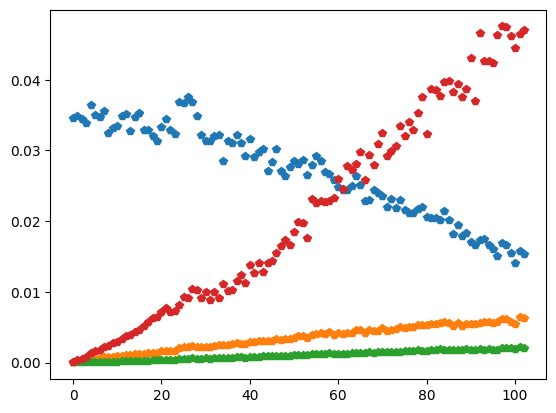

In [17]:
for i in range(len(reagents_spectra)):
    plt.plot(range(len(proportions_in_times)), [prop[i] for prop in proportions_in_times], 'p')

In [18]:
with open(results_paths[experiment_name]+'proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(proportions_in_times, f)

In [19]:
with open(results_paths[experiment_name]+'noise_proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(noise_proportions_in_times, f)

In [20]:
with open(results_paths[experiment_name]+'common_horizontal_axis_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(common_horizontal_axis, f)

In [21]:
with open(results_paths[experiment_name]+'noise_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(noise, f)

In [22]:
with open(results_paths[experiment_name]+'noise_in_components_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(noise_in_components, f)